### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# TODO check torchtext version
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from collections import deque
from tqdm import tqdm
import numpy as np

In [5]:
import wandb
from contextlib import contextmanager
WANDB_GLOBAL = dict(
    entity='ermekaitygulov',
    group='Baseline',
    anonymous='allow',
    project='NLP-LAB2',
    reinit=True
)

In [6]:
@contextmanager
def wandb_log(model_name, model_config=None):
    try:
        model_config = model_config or {}
        name = f'{model_name}_{wandb.util.generate_id()}'
        run = wandb.init(name=name, config=model_config, **WANDB_GLOBAL)
        yield run
    finally:
        run.finish()

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [7]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [8]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legac

In [9]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [11]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [12]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9160
Unique tokens in target (en) vocabulary: 6654


Here are tokens from original (RU) corpus:

In [13]:
SRC.vocab.itos[::1000]

['<unk>',
 '350',
 'быстро',
 'книги',
 'apartman',
 'этна',
 'ps3',
 '115',
 'каилуа',
 'фешенебельном']

And from target (EN) corpus:

In [14]:
TRG.vocab.itos[::1000]

['<unk>', '29', 'eastern', 'grab', 'morocco', 'taunus', 'min']

And here is example from train dataset:

In [15]:
print(vars(train_data.examples[9]))

{'trg': ['vegan', ',', 'vegetarian', ',', 'gluten', '-', 'free', ',', 'and', 'dairy', '-', 'free', 'alternatives', 'are', 'also', 'available', 'with', 'prior', 'request', '.'], 'src': ['по', 'предварительному', 'запросу', 'вам', 'подадут', 'вегетарианские', 'блюда', ',', 'блюда', 'безглютеновой', 'диеты', 'и', 'блюда', ',', 'приготовленные', 'без', 'использования', 'молочных', 'продуктов', '.']}


Let's check the length distributions:

Length distribution in Train data


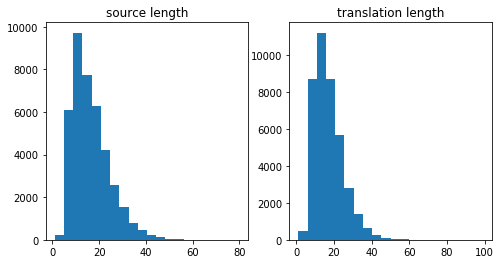

In [16]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


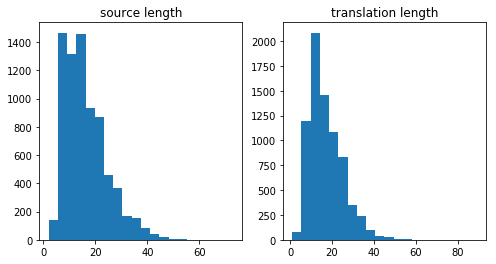

In [17]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [20]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [21]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)



[torchtext.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 52x64 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 45x64 (GPU 0)]
torch.Size([45, 64]) torch.Size([52, 64])


In [22]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [25]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9160, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6654, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6654, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [26]:
# dont forget to put the model to the right device
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,818,302 trainable parameters


In [27]:
def train(model, iterator, optimizer, criterion, clip, global_step=0, log_window_size=10):
    model.train()
    
    epoch_loss = 0
    loss_window = deque(maxlen=log_window_size)
    tqdm_iterator = tqdm(iterator)
    for i, batch in enumerate(tqdm_iterator):
        optimizer.zero_grad()
        
        src = batch.src
        trg = batch.trg        
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        loss_window.append(loss.cpu().data.numpy())
        if (i+1) % log_window_size==0:
            log_dict = dict()
            mean_loss = np.mean(loss_window)
            log_dict['train_loss'] = mean_loss
            log_dict['train_step'] = global_step
            if tqdm_iterator._ema_dt():
                log_dict['train_speed(batch/sec)'] = tqdm_iterator._ema_dn()/ tqdm_iterator._ema_dt()
            wandb.log(log_dict)
            tqdm_iterator.set_postfix(train_loss = mean_loss)
            
        global_step += 1
        
    return epoch_loss / len(iterator), global_step

In [28]:
def evaluate(model, iterator, criterion, global_step=0, log_window_size=10):
    model.eval()
    epoch_loss = 0
    loss_window = deque(maxlen=log_window_size)
    tqdm_iterator = tqdm(iterator)
    with torch.no_grad():
    
        for i, batch in enumerate(tqdm_iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            loss_window.append(loss.item())
            
            if (i+1) % log_window_size==0:
                log_dict = dict()
                mean_loss = np.mean(loss_window)
                log_dict['val_loss'] = mean_loss
                log_dict['val_step'] = global_step
                wandb.log(log_dict)
                tqdm_iterator.set_postfix(train_loss = mean_loss)
            
            global_step += 1
        
    return epoch_loss / len(iterator), global_step

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 10
CLIP = 1

train_step = 0
val_step = 0
best_valid_loss = float('inf')
model_name = 'test'
model_config = {}

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

name = f'{model_name}_{wandb.util.generate_id()}'
if wandb.run:
    wandb.finish()
wandb.init(name=name, config=model_config, **WANDB_GLOBAL)
wandb.watch(model, criterion, log_freq=100)

train_loss,4.42328
train_step,619
train_speed(batch/sec),7.68775
_step,65
_runtime,87
_timestamp,1620318317
val_loss,5.55581
val_step,39


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_speed(batch/sec),▃▁▅▃▃▄▄▄▄▇▄▄▄▆▆▃▆▄▄▄▄▃▆▆▅█▅▅▃▅▃▆▄▄▆▃▃▃▄▃
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_loss,▁▅▆█
val_step,▁▃▆█


wandb: wandb version 0.10.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [44]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_step = train(
        model,
        train_iterator,
        optimizer,
        criterion,
        CLIP,
        train_step)

    valid_loss, val_step = evaluate(
        model,
        valid_iterator,
        criterion,
        val_step,
    )

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 40/40 [00:00<00:00, 40.11it/s, train_loss=5.62]

Epoch: 01 | Time: 1m 19s
	Train Loss: 4.967 | Train PPL: 143.603
	 Val. Loss: 5.118 |  Val. PPL: 167.035


In [45]:
FINISH = True
if FINISH:
    wandb.finish()

train_loss,4.31892
train_step,619
train_speed(batch/sec),7.96099
_step,65
_runtime,81
_timestamp,1620318420
val_loss,5.61769
val_step,39


train_loss,█▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁
train_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_speed(batch/sec),▄▃▄▄▆▄▅▄█▅▇▅▆▂▅▂▄▅█▁▆▅▃▆▆▂▅▆▅▇▆▆▆▅▅▇▇▅▅▅
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,▁▅▇█
val_step,▁▃▆█


__Let's take a look at our network quality__:

In [44]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [45]:
batch = next(iter(test_iterator))

In [46]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: all units are functionally furnished .
Generated: rooms with a .

Original: guests enjoy free parking .
Generated: free parking .



In [47]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [48]:
import tqdm

In [49]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

118it [00:02, 40.96it/s]


In [50]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.017227533948315

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

In [67]:
i = 80
print(generated_text[i])
print(original_text[i])

['a', '24', '-', 'hour', 'front', 'desk', '.']
['you', 'will', 'find', 'a', '24', '-', 'hour', 'front', 'desk', 'at', 'the', 'property', '.']
